# Классификация токсичных комментариев

Условный интернет-магазин запускает новый сервис - теперь пользователи могут редактировать и дополнять описания товаров, то есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

In [2]:
#!pip install wordcloud

In [150]:
import pandas as pd
import numpy as np
import math
import string
import re
import scipy.stats as st
import matplotlib.pyplot as plt
import time
import nltk

from tqdm.auto import tqdm, trange

from nltk.stem import *
from nltk.stem import WordNetLemmatizer 
lemmatizing = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from string import punctuation

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

STATE = 12345
SIZE = 0.25 #test_size for train_test_split

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

STOP_WORDS = stopwords.words('english')
STOP_WORDS.extend(['\n'])

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [157]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info()
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df.duplicated().sum()))

def remove_punctuation(text):
    """функция ооъбработки и очистки текста"""
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return clean_text

def gett_lemm(text):
    """функция леммитизации"""
    text = text.apply(lambda x: word_tokenize(x))
    text = text.apply(lambda x: [w for w in x if not w in STOP_WORDS])
    text = text.apply(lambda x: ' '.join([lemmatizing.lemmatize(i, "v") for i in x]))
    return text
        
def str_corpus(corpus):
    """функция для получения текстовой строки из списка слов"""
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_corpus(data):
    """функция получения списка всех слов в корпусе"""
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

def get_wordCloud(corpus):
    """функция получения облака слов"""
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOP_WORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=STATE
                         ).generate(str_corpus(corpus))
    return wordCloud

def procWordCloud(df):
    """визуализация облака слов"""
    corpus = get_corpus(df.values)
    procWordCloud = get_wordCloud(corpus)
    fig = plt.figure(figsize=(30,30))
    plt.subplot(1, 2, 1)
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.show()
    print('Количество уникальных слов - {}'.format(len(corpus)))

def split_data(features, target):
    """функция для формирования обучающей, валидационной и тестовой выборок"""
    (features_train, features_test, target_train, target_test) = train_test_split(features, target, test_size = SIZE, random_state=12345)
    return (features_train, features_test, target_train, target_test)

def downsample(features, target, fraction):
    """функция уменьшения выборки для борьбы с дисбалансом"""
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=1/fraction, random_state=STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=1/fraction, random_state=STATE)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=STATE)
    return features_downsampled, target_downsampled

def fit_models(model, params, features_train, target_train, features_test, target_test):
    """функция обучения и оценки моделей"""
    grid = GridSearchCV(model, 
                        param_grid=params, 
                        scoring='f1',
                        cv=5,
                        verbose = 1, 
                        n_jobs = -1)
               
    grid.fit(features_train, target_train)
    
    predict = grid.predict(features_test)
    
    score_train = grid.score(features_train,
                             target_train)
    
    score_test = grid.score(features_test, 
                            target_test)
    return score_train, score_test, predict

def show_error_matrix(target, predict):
    """функция построения матрицы ошибок"""
    cm = confusion_matrix(target, predict)
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=grid_sgd.classes_)
    fig, ax = plt.subplots(figsize=(10,10))
    cmd_obj.plot(ax=ax)
    plt.show() 

Создадим датафрейм для внесения результатов:

- model_name - наименование модели
- f1_score - качество предсказания;

In [113]:
column_names = ['model_name', 'f1_score']
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,model_name,f1_score


In [54]:
def update_results(model_name, f1_score, df_results):
    """функция обновления датафрейма с результатами"""
    result_row_str= [model_name, f1_score]
    rows = [pd.Series(result_row_str, index=df_results.columns)]
    df_results=df_results.append(rows,ignore_index=True)
    return(df_results)

In [55]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

## Подготовка

In [56]:
review(df)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
Дубликатов не обнаружено


### Подготовка текста

Создим датасет `df_for_learning`, на основании данных из исходной выборки

In [57]:
df_for_learning = df.copy(deep=True)

Создим столбец `processed_text` на основе данных столбца `text`, данные нового столбца приведем к нижнему регистру и данные очистим от слов паразитов и знаков пунктуации.

In [58]:
df_for_learning['processed_text'] = df_for_learning['text'].apply(lambda x: remove_punctuation(x.lower()))
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: x.split(' '))
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: [token for token in x if token not in STOP_WORDS\
                                                                                     and token != " " \
                                                                                     and token.strip()
                                                                                     not in punctuation])
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: ' '.join(x))

In [59]:
review(df_for_learning)

,text,toxic,processed_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations well use tools well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intending...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            159571 non-null  object
 1   toxic           159571 non-null  int64 
 2   processed_text  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB
Дубликатов не обнаружено


Выполним леммитизацию очищенного текста - леммы соберем в столбец `text_lemm`.

In [60]:
df_for_learning['text_lemm'] = gett_lemm(df_for_learning['processed_text'])

In [61]:
review(df_for_learning)

,text,toxic,processed_text,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...,make real suggestions improvement wonder secti...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations well use tools well talk,congratulations well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...,vandalism matt shirvington article revert plea...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intending...,sorry word nonsense offensive anyway intend wr...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow,alignment subject contrary dulithgow


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            159571 non-null  object
 1   toxic           159571 non-null  int64 
 2   processed_text  159571 non-null  object
 3   text_lemm       159571 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB
Дубликатов не обнаружено


### Исследовательский анализ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


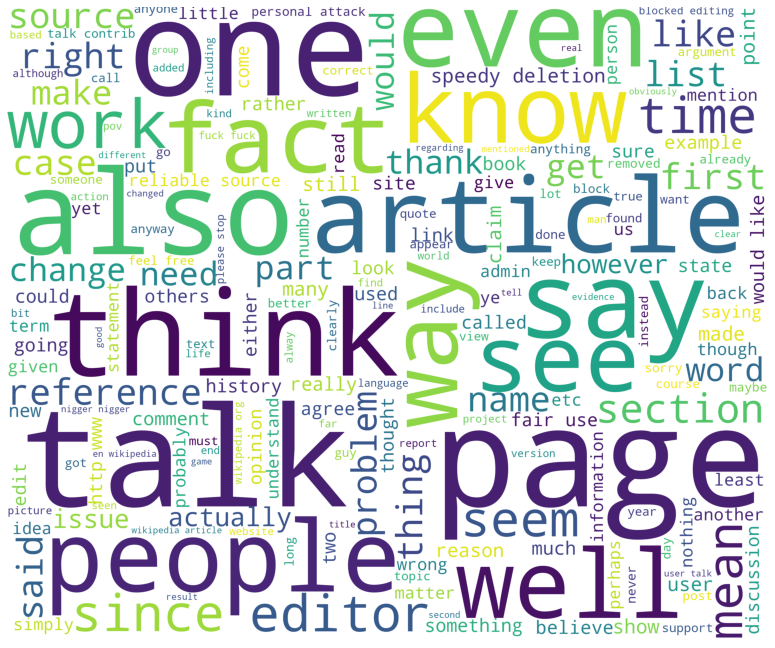

Количество уникальных слов - 5537156


In [17]:
procWordCloud(df_for_learning['processed_text'])

In [18]:
true_toxic = df_for_learning.loc[df['toxic'] == 0]

In [19]:
false_toxic = df_for_learning.loc[df['toxic'] == 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


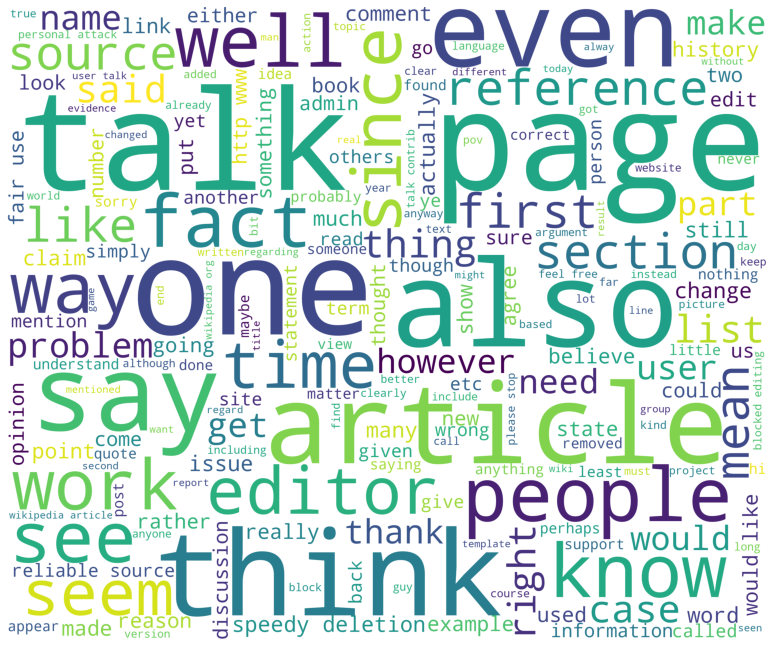

Количество уникальных слов - 5071297


In [20]:
procWordCloud(true_toxic['processed_text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


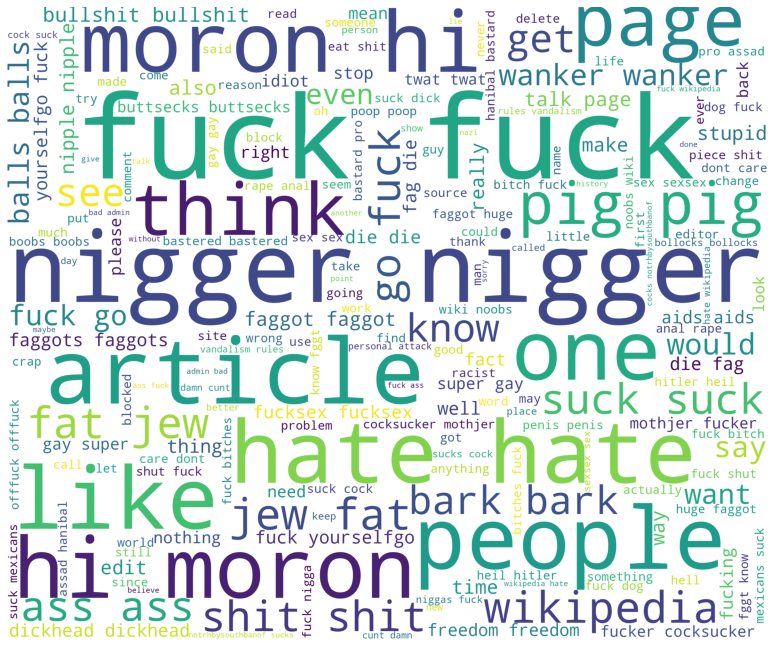

Количество уникальных слов - 465859


In [21]:
procWordCloud(false_toxic['processed_text'])

### Вывод

- для обучения моделей был создан датасет `df_for_learning`, который были скопированы данные из исходной выборки;
- создан столбец `processed_text` на основе данных столбца `text`, где была проведена сл. работа с текстом:
    - данные были приведены к нижнему регистру;
    - данные были очищены от слов паразитов и знаков пунктуации;
    - произведена леммитизация очищенного текста - леммы были внесены в столбец `text_lemm`
- выборка содержит `5537156` уникальных слов;
- позитивные комментарии содержат `5071297` уникальных слова, среди которых выражаются - `talk`, `page`, `people`, `article`, `one`, `even`;
- негативные комментарии содержат `465859` уникальных слова, среди которых выражаются - `fuck`, `moron`, `hate`, `people`, `nigger`, `pig`.

## Обучим модели и оценим их качество.

Для обучения будем использовать сл. алгоритмы:

- `Naive Bayes Classifier`;
- `Linear Support Vector Machine`;
- `Random Forest Classifier`;
- `Logistic Regression`.

Векторизацию выполним при помощи `Tfidfvectorizer`.

Качество моделей оценим кросс-валидацией с пятью блоками.

### Подготовим признаки

In [62]:
features = df_for_learning['text_lemm']
target = df_for_learning['toxic']

Разделим выборку на тренировочную и тестовую

In [63]:
(features_train, 
 features_test,
 target_train,
 target_test) = split_data(features,
                           target)

In [64]:
print(features_train.shape)
print(target_train.shape)

(119678,)
(119678,)


In [65]:
print(features_test.shape)
print(target_test.shape)

(39893,)
(39893,)


#### Баланс классов

In [66]:
balance_rate = list(target_train.value_counts(normalize=True))

In [67]:
features_downsampled, target_downsampled = downsample(features_train, 
                                                      target_train, 
                                                      math.ceil(balance_rate[0]/balance_rate[1]))

In [68]:
target_downsampled.value_counts()

1    12138
0    11949
Name: toxic, dtype: int64

### Определим лучшую модель

- для модели `Naive Bayes Classifier` обучение произведем на выборке с балансированными классами техникой `downsampling`;
- для моделей `Linear Support Vector Machine`, `Random Forest Classifier` и `Logistic Regression` будем использовать параметр `class_weight='balanced'`

#### `Naive Bayes Classifier`

In [116]:
nb = Pipeline([('vect', TfidfVectorizer()),
               ('clf', MultinomialNB())
              ])

In [117]:
params_nb = {'vect__stop_words': [None, STOP_WORDS]}

In [118]:
(score_train_nb,
 score_test_nb,
 predict_nb) = fit_models(nb, 
                          params_nb, 
                          features_downsampled, 
                          target_downsampled, 
                          features_test, 
                          target_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [119]:
df_results = update_results('Naive Bayes Classifier on the training set', 
                            score_train_nb, 
                            df_results)
df_results = update_results('Naive Bayes Classifier on the test set', 
                            score_test_nb, 
                            df_results)

#### `Linear Support Vector Machine`

In [120]:
sgd = Pipeline([('vect', TfidfVectorizer()),
               ('clf', SGDClassifier(random_state=STATE,
                                     max_iter=1000,
                                     class_weight='balanced'))
              ])

In [121]:
params_sgd = {'vect__stop_words': [None, STOP_WORDS],
              'clf__loss':['hinge', 'log', 'modified_huber'],
              'clf__learning_rate':['optimal', 'adaptive'],
              'clf__eta0':[0.1, 0.5]}

In [122]:
(score_train_sgd,
 score_test_sgd,
 predict_sgd) = fit_models(sgd, 
                           params_sgd, 
                           features_train, 
                           target_train, 
                           features_test, 
                           target_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [123]:
df_results = update_results('Linear Support Vector Machine on the training set', 
                            score_train_sgd, 
                            df_results)
df_results = update_results('Linear Support Vector Machine on the test set', 
                            score_test_sgd, 
                            df_results)

#### `Random Forest Classifier`

In [124]:
rfc = Pipeline([('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(random_state=STATE,
                                               class_weight='balanced'))
               ])

In [125]:
params_rfc = {'vect__stop_words': [None, STOP_WORDS],
              'clf__n_estimators':[10,30,50], 
              'clf__max_depth':[1,5,10]}

In [126]:
(score_train_rfc,
 score_test_rfc,
 predict_rfc) = fit_models(rfc, 
                           params_rfc, 
                           features_train, 
                           target_train, 
                           features_test, 
                           target_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [127]:
df_results = update_results('Random Forest Classifier on the training set', 
                            score_train_rfc, 
                            df_results)
df_results = update_results('Random Forest Classifier on the test set', 
                            score_test_rfc, 
                            df_results)

#### `Logistic Regression`

In [128]:
lr = Pipeline([('vect', TfidfVectorizer()),
               ('clf', LogisticRegression(random_state=STATE, class_weight='balanced'))
              ])

In [129]:
params_lr = {'vect__stop_words': [None, STOP_WORDS],
             'clf__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [130]:
(score_train_lr,
 score_test_lr, 
 predict_lr) = fit_models(lr,
                          params_lr,
                          features_train, 
                          target_train, 
                          features_test,
                          target_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ialek\.conda\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [131]:
df_results = update_results('Logistic Regression on the training set', 
                            score_train_lr, 
                            df_results)
df_results = update_results('Logistic Regression on the test set', 
                            score_test_lr, 
                            df_results)

### Оценим качество лучших моделей на тестовой выборке 

In [132]:
df_results

,model_name,f1_score
0,Naive Bayes Classifier on the training set,0.922866
1,Naive Bayes Classifier on the test set,0.620390
2,Linear Support Vector Machine on the training set,0.833434
3,Linear Support Vector Machine on the test set,0.753863
4,Random Forest Classifier on the training set,0.331228
5,Random Forest Classifier on the test set,0.326991
6,Logistic Regression on the training set,0.832883
7,Logistic Regression on the test set,0.752386


## Общий вывод

Для обучения моделей текст был обработан сл. образом:
- данные были приведены к нижнему регистру, очищены от слов паразитов и знаков пунктуации - внесены в столбец `processed_text`;
- произведена леммитизация очищенного текста - леммы были внесены в столбец `text_lemm`.

После обработки текста был проведен исследовательский анализ, из чего были сделаны сл. выводы:
- выборка содержит `5537156` уникальных слов;
- позитивные комментарии содержат `5071297` уникальных слова, среди которых выражаются - `talk`, `page`, `people`, `article`, `one`, `even`;
- негативные комментарии содержат `465859` уникальных слова, среди которых выражаются - `fuck`, `moron`, `hate`, `people`, `nigger`, `pig`.

Для обучения использовались сл. алгоритмы:

- `Naive Bayes Classifier`;
- `Linear Support Vector Machine`;
- `Random Forest Classifier`;
- `Logistic Regression`.

- выборка была разделена на обучающую и тестовую в соотношении 75:25;
- векторизация выполнена при помощи `Tfidfvectorizer`;
- для модели `Naive Bayes Classifier` обучение произведено на выборке с балансированными классами техникой `downsampling`;
- для моделей `Linear Support Vector Machine`, `Random Forest Classifier` и `Logistic Regression` использован параметр `class_weight='balanced'`;
- качество моделей оценено кросс-валидацией с пятью блоками.

Все четыре модели показали хороший результат на тренировочной выборке. На тестовой же выборке порог качества в не менее `0.75` показали модели - `Linear Support Vector Machine` и `Logistic Regression`.

In [160]:
print('Score for Linear Support Vector Machine on the test set: %0.3f' % score_test_sgd)

Score for Linear Support Vector Machine on the test set: 0.754


In [161]:
print('Score for Logistic Regression on the test set: %0.3f' % score_test_lr)

Score for Logistic Regression on the test set: 0.752


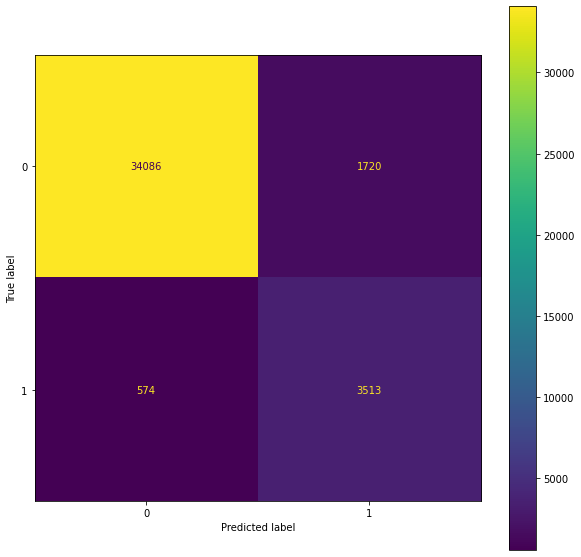

In [158]:
show_error_matrix(target_test, predict_sgd)

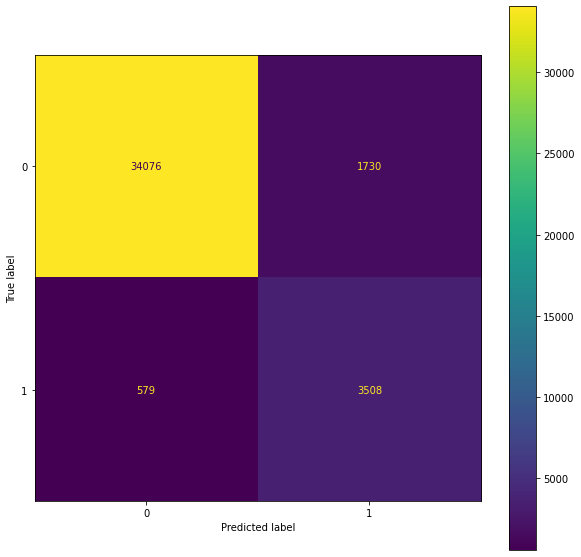

In [159]:
show_error_matrix(target_test, predict_lr)